In [110]:
import datetime

from pprint import pprint
import numpy as np
import pandas as pd
from numba import jit, f8, i8, i4, b1, void

import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter import Line
from plotly.graph_objs import Scatter

from scipy.io import loadmat
from sklearn.model_selection import train_test_split

In [94]:
mat = loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']

mat = loadmat('ex4weights.mat')
Theta1 = mat['Theta1']
Theta2 = mat['Theta2']

X.shape, y.shape, Theta1.shape, Theta2.shape

((5000, 400), (5000, 1), (25, 401), (10, 26))

In [95]:
X_train, X_test_base, y_train, y_test_base = train_test_split(X, y.ravel(), test_size=0.6)
X_cv, X_test, y_cv, y_test = train_test_split(X_test_base, y_test_base, test_size=0.5)
print(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape)

(2000, 400) (2000,) (1500, 400) (1500,) (1500, 400) (1500,)


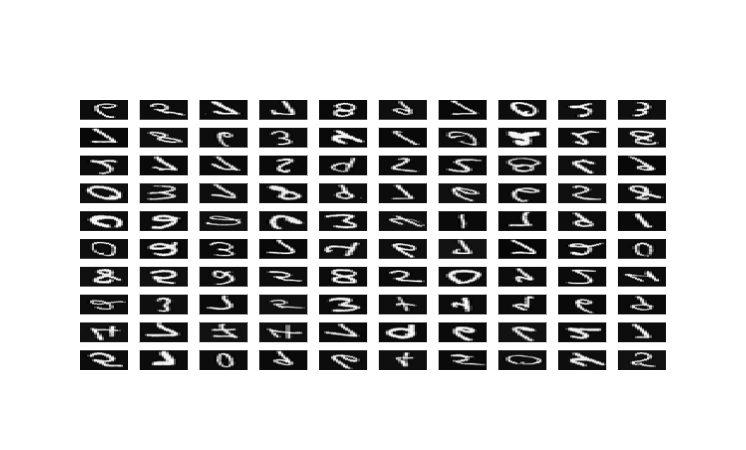

In [4]:
def display(x):
    fig = make_subplots(rows=10, cols=10)

    for i in range(0, 100):
        r = i//10 + 1
        c = i%10 + 1
        fig.add_trace(
            go.Heatmap(z=x[i].reshape(20, 20, order='F'), 
                       colorscale=[[0, 'rgb(0,0,0)'], [1, 'rgb(255,255,255)']], showscale=False),
            row=r, col=c)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.show()

display(X_train)

In [96]:
z = lambda th, x: x @ th
sigmoid = lambda z: 1 / (1 + np.exp(-z))
delta_sigmoid = lambda z: sigmoid(z) * (1 - sigmoid(z))

In [123]:
y_train_k = np.ones((y_train.shape[0], 10))
for i in range(y_train.shape[0]):
    for k in range(10):
        if k+1 == y_train[i]:
            y_train_k[i][k] = 1
        else:
            y_train_k[i][k] = 0

print(y_train_k.shape, y_train[1], y_train_k[1])

y_k = np.ones((y.shape[0], 10))
for i in range(y.shape[0]):
    for k in range(10):
        if k+1 == y[i]:
            y_k[i][k] = 1
        else:
            y_k[i][k] = 0
            

y_cv_k = np.ones((y_cv.shape[0], 10))
for i in range(y_cv.shape[0]):
    for k in range(10):
        if k+1 == y_cv[i]:
            y_cv_k[i][k] = 1
        else:
            y_cv_k[i][k] = 0

(2000, 10) 8 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [100]:
def cost(x, y, h, th1, th2, lambda_):
    m = x.shape[0]
    J = 1/m * (-y * np.log(h) - (1-y) * np.log(1 - h)).sum()
    c = lambda_ / (2 * m) * ( (th1[:, 1:] ** 2).sum() + (th2[:, 1:] ** 2).sum() )
    return J + c


In [146]:
def nn_cost(x1, th1, th2, y, lambda_=1):
    z1 = x1
    a1 = np.c_[np.ones(x1.shape[0]), x1]
#     print(a1.shape, Theta1.shape)
    z2 = z(th1.T, a1)
#     print(z2.shape)
    a2 = sigmoid(z2)
#     print(a2.shape)
    a2 = np.c_[np.ones(a2.shape[0]), a2]
#     print(a2.shape, Theta2.shape)
    z3 = z(th2.T, a2)
#     print(z3.shape)
    a3 = sigmoid(z3)
#     print(a3.shape)
    h = a3

    J = cost(x1, y, h, th1, th2, lambda_)
#     print(J)

    d3 = h - y
    d2 = z3 @ th2
    d2 = d2[:, 1:] - delta_sigmoid(z2)
    d1 = z2 @ th1
#     print(z1.shape, d1.shape)
    d1 = d1[:, 1:] - delta_sigmoid(z1)

    delta2 = np.zeros(th2.shape)
    delta2 -= (d3.T @ a2)
    delta1 = np.zeros(th1.shape)
    delta1 -= (d2.T @ a1)

    grad1 = 1/(y.shape[0]) * delta1
    grad2 = 1/(y.shape[0]) * delta2
    
    return a3, grad1, grad2, J


h, grad1, grad2, j = nn_cost(X_train, Theta1, Theta2, y_train_k, 1)
print(grad1.shape, grad2.shape, j)
p = h.argmax(1) + 1
(p == y_train).mean()

(25, 401) (10, 26) 0.5456152628066051


0.971

In [147]:
h, grad1, grad2, j = nn_cost(X, Theta1, Theta2, y_k, 1)

In [148]:
def gradient_checking_nn(x, y, th1, th2, lambda_, epsilone=1e-4):
    grad1 = np.zeros(th1.shape)
    grad2 = np.zeros(th2.shape)

    for i in range(th1.shape[0]):
        for j in range(th1.shape[1]):
            th1_sub = th1 - epsilone
            th1_add = th1 + epsilone
            h_sub, *_ = forward(x, th1_sub, th2)
            h_add, *_ = forward(x, th1_add, th2)
            cost_sub = cost(x, y, h_sub, th1_sub, th2, lambda_)
            cost_add = cost(x, y, h_add, th1_add, th2, lambda_)
            grad1[i, j] = (cost_add - cost_sub) / (2 * epsilone)
            
    for i in range(th2.shape[0]):
        for j in range(th2.shape[1]):
            th2_sub = th2 - epsilone
            th2_add = th2 + epsilone
            h_sub, *_ = forward(x, th1, th2_sub)
            h_add, *_ = forward(x, th1, th2_add)
            cost_sub = cost(x, y, h_sub, th1, th2_sub, lambda_)
            cost_add = cost(x, y, h_add, th1, th2_add, lambda_)
            grad2[i, j] = (cost_add - cost_sub) / (2 * epsilone)

    return grad1, grad2  
   
# X_train.shape, y_train_k.shape, Theta1.shape
# gradient_checking_nn(X_train, y_train_k, Theta1, Theta2, 1)
t1 = random_weight(400, 25); print(t1.shape)
t2 = random_weight(25, 10); print(t2.shape)
# gradient_checking_nn(X_cv, y_cv_k, t1, t2, 1)

(25, 401)
(10, 26)


In [149]:
def random_weight(in_size, out_size):
    epsilon = 0.12
    return np.random.uniform(-epsilon, epsilon, (out_size, 1 + in_size))
    
random_weight(100,20).shape

(20, 101)

In [157]:
# cost(X_train, y_train_k, h, t1, t2, lambda_)

t1 = random_weight(400, 25); print(t1.shape)
t2 = random_weight(25, 10); print(t2.shape)

lambda_ = 1
iter_ = 400
for i in range(iter_):
    h, grad1, grad2, J = nn_cost(X_train, t1, t2, y_train_k, lambda_)
    t1 = t1 + grad1 * (lambda_ / X_train.shape[0])
    t2 = t2 + grad2 * (lambda_ / X_train.shape[0])
    sys.stdout.write(f"\r{i}: {J}")
    sys.stdout.flush()
    time.sleep(0)

h, grad1, grad2, J = nn_cost(X_train, t1, t2, y_train_k, lambda_)
grad1.shape, grad2.shape

(25, 401)
(10, 26)
399: 4.9775570100236886

((25, 401), (10, 26))

In [158]:
h, grad1, grad2, j = nn_cost(X_train, t1, t2, y_train_k, 1)
p = h.argmax(1) + 1
(p == y_train).mean()

0.1195